# DSE Course 1, Session 7: Predicting Product Quality

**Instructor**: Wesley Beckner

**Contact**: wesleybeckner@gmail.com

<br>

---

<br>

In this session we will predct wine quality based on several chemical features. We will highlight key insights about our data being used in our predictive model: things like colinearity between features and feature skewness. For now we will stop at simply assessing the presence of these phenomenon in our data. In later sessions, we will apply strategies to improve our model in light of this phenomenon. 

<br>

---

<br>

<a name='top'></a>

# Contents

* 7.1 [Preparing Environment and Importing Data](#prepare)
  * 7.1.1 [Import Packages](#packages)
  * 7.1.2 [Load Dataset](#dataset)
* 7.2 [Exploratory Data Analysis (EDA)](#eda)
  * 7.2.1 [First Look: Shape, Nulls, Description](#first)
  * 7.2.2 [Descriptive Statistics](#statistics)
    * 7.2.2.1 [Statistics By Type](#type)
    * 7.2.2.2 [Statistcs By Quality](#quality)
  * 7.2.3 [Inferential Statistics](#infer) (ANOVA)
    * 7.2.3.1 [Inference of Feature by Wine Type](#inference1)
    * 7.2.3.2 [Inference of Feature by Quality Label](#inference2)
  * 7.2.4 [Feature Colinearity](#detectcolinearity)
* 7.3 [Feature Engineering](#engineering)
  * 7.3.1 [Feature Skewness](#skewness)
  * 7.3.2 [Feature Colinearity](#colinearity)
  * 7.3.3 [Feature Normalization](#normalization)
  * 7.3.4 [Feature Selection](#selection)
  * 7.4.5 [Dimensionality Reduction](#dimensionality)
* 7.4 [Modeling](#modeling)
  * 7.4.1 [Wine Type](#winetype)
  * 7.4.2 [Wine Quality](#winequality)

<br>

---


<a name="prepare"></a>
## 7.1 Preparing Environment and Importing Data
[back to top](#top)

<a name='packages'></a>
### 7.1.1 Import Packages
[back to top](#top)

Load libraries which will be needed in this Notebook



In [ ]:
# Pandas library for the pandas dataframes
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import plotly.express as px
import random
import scipy.stats as stats
import seaborn as sns
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

<a name='dataset'></a>
### 7.1.2 Load Dataset
[back to top](#top)


In [ ]:
df = pd.read_csv("https://raw.githubusercontent.com/wesleybeckner/"\
      "ds_for_engineers/main/data/wine_quality/winequalityN.csv")

In [ ]:
df['quality_label'] = df['quality'].apply(lambda x: 'low' if x <=5 else 'med' if x <= 7 else 'high')

In [ ]:
df.columns = df.columns.str.replace(' ', '_')

<a name='eda'></a>
## 7.2 Exploratory Data Analysis (EDA)
[back to top](#top)

<a name='first'></a>
### 7.2.1 First Look: Shape, Nulls, Description
[back to top](#top)

In [ ]:
df.shape

(6497, 16)

In [ ]:
df.describe()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality,type_encoding,quality_encoding
count,6487.000000,6489.000000,6494.000000,6495.000000,6495.000000,6497.000000,6497.000000,6497.000000,6488.000000,6493.000000,6497.000000,6497.000000,6497.000000,6497.000000
mean,7.216579,0.339691,0.318722,5.444326,0.056042,30.525319,115.744574,0.994697,3.218395,0.531215,10.491801,5.818378,0.753886,0.663537
std,1.296750,0.164649,0.145265,4.758125,0.035036,17.749400,56.521855,0.002999,0.160748,0.148814,1.192712,0.873255,0.430779,0.533152
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000,0.000000,0.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000,5.000000,1.000000,0.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,6.000000,1.000000,1.000000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000,6.000000,1.000000,1.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000,1.000000,2.000000


In [ ]:
df.isnull().sum()

type                     0
fixed_acidity           10
volatile_acidity         8
citric_acid              3
residual_sugar           2
chlorides                2
free_sulfur_dioxide      0
total_sulfur_dioxide     0
density                  0
pH                       9
sulphates                4
alcohol                  0
quality                  0
quality_label            0
type_encoding            0
quality_encoding         0
dtype: int64

In [ ]:
df.dropna(inplace=True)

In [ ]:
class_tp = {'red': 0, 'white': 1}
y_tp = df['type'].map(class_tp)
df['type_encoding'] = y_tp

class_ql = {'low':0, 'med': 1, 'high': 2}
y_ql = df['quality_label'].map(class_ql)
df['quality_encoding'] = y_ql

<a name='statistics'></a>
### 7.2.2 Descriptive Statistics
[back to top](#top)

In [ ]:
def desc(mydf, group=None, target=None):
  if group == None:
    skew = mydf.skew()
    kurt = mydf.kurtosis()
    pear = mydf.corr()['quality']
    spear = mydf.corr('spearman')['quality']
    null = mydf.isnull().sum()
    med = mydf.median()

    dff = pd.DataFrame([skew, kurt, pear, spear, null, med])
    dff = dff.T
    dff.columns = ['skew', 'kurtosis', 'pearsons _quality', 'spearman _quality', 'null count', 'median']
  else:
    dff = pd.DataFrame()
    for cat in mydf[group].unique():
      subdf = mydf.loc[mydf[group] == cat]
      subdf = subdf.drop([group],axis=1)
      skew = subdf.skew()
      kurt = subdf.kurtosis()
      pear = subdf.corr()['quality']
      spear = subdf.corr('spearman')['quality']
      null = subdf.isnull().sum()
      med = subdf.median()

      dfff = pd.DataFrame([skew, kurt, pear, spear, null, med])
      dfff = dfff.T
      dfff.columns = ['skew', 'kurtosis', 'pearsons _quality', 'spearman _quality', 'null count', 'median']
      arrays = [[cat]*len(list(dfff.index)),list(dfff.index.values)]
      tuples = list(zip(*arrays))
      index = pd.MultiIndex.from_tuples(tuples, names=[group, "feature"])
      dfff.index = index
      dff = pd.concat([dff, dfff])
  return dff

<a name='type'></a>
#### 7.2.2.1 Statistics by Type
[back to top](#top)

In [ ]:
desc(df, group='type')

skew   kurtosis  ...  null count     median
type  feature                                    ...                       
white fixed acidity         0.647981   2.176560  ...         8.0    6.80000
      volatile acidity      1.578595   5.095526  ...         7.0    0.26000
      citric acid           1.284217   6.182036  ...         2.0    0.32000
      residual sugar        1.076601   3.469536  ...         2.0    5.20000
      chlorides             5.023412  37.560847  ...         2.0    0.04300
      free sulfur dioxide   1.406745  11.466342  ...         0.0   34.00000
      total sulfur dioxide  0.390710   0.571853  ...         0.0  134.00000
      density               0.977773   9.793807  ...         0.0    0.99374
      pH                    0.458402   0.532552  ...         7.0    3.18000
      sulphates             0.977361   1.589847  ...         2.0    0.47000
      alcohol               0.487342  -0.698425  ...         0.0   10.40000
      quality               0.155796   0.216526  ...         0.0    6.00000
red   fixed acidity         0.982192   1.132624  ...         2.0    7.90000
      volatile acidity      0.672862   1.226846  ...         1.0    0.52000
      citric acid           0.317891  -0.788476  ...         1.0    0.26000
      residual sugar        4.540655  28.617595  ...         0.0    2.20000
      chlorides             5.680347  41.715787  ...         0.0    0.07900
      free sulfur dioxide   1.250567   2.023562  ...         0.0   14.00000
      total sulfur dioxide  1.515531   3.809824  ...         0.0   38.00000
      density               0.071288   0.934079  ...         0.0    0.99675
      pH                    0.194803   0.814690  ...         2.0    3.31000
      sulphates             2.429115  11.712632  ...         2.0    0.62000
      alcohol               0.860829   0.200029  ...         0.0   10.20000
      quality               0.217802   0.296708  ...         0.0    6.00000

[24 rows x 6 columns]

<a name='quality'></a>
#### 7.2.2.2 Statistics by Quality
[back to top](#top)

In [ ]:
desc(df, group='quality label')

skew   kurtosis  ...  null count     median
quality label feature                                    ...                       
med           fixed acidity         1.799884   5.064626  ...         4.0    6.90000
              volatile acidity      1.514121   2.728471  ...         6.0    0.27000
              citric acid           0.684103   4.685942  ...         2.0    0.31000
              residual sugar        1.698797   7.663582  ...         2.0    3.00000
              chlorides             4.434214  35.792975  ...         1.0    0.04500
              free sulfur dioxide   0.631469   0.589060  ...         0.0   29.00000
              total sulfur dioxide -0.057963  -0.444789  ...         0.0  116.00000
              density               0.993299  10.503343  ...         0.0    0.99400
              pH                    0.358194   0.424136  ...         6.0    3.21000
              sulphates             1.412261   5.670834  ...         2.0    0.51000
              alcohol               0.243804  -0.776162  ...         0.0   10.80000
              quality               1.004788  -0.990908  ...         0.0    6.00000
              type                       NaN        NaN  ...         0.0        NaN
low           fixed acidity         1.653980   5.244718  ...         5.0    7.10000
              volatile acidity      1.250350   1.849614  ...         2.0    0.34000
              citric acid           0.362065   0.283412  ...         1.0    0.29000
              residual sugar        1.072275   0.101941  ...         0.0    2.90000
              chlorides             5.469593  46.052993  ...         1.0    0.05200
              free sulfur dioxide   1.790344  13.311558  ...         0.0   26.00000
              total sulfur dioxide  0.026714  -0.473243  ...         0.0  124.00000
              density              -0.190965  -0.308145  ...         0.0    0.99600
              pH                    0.452618   0.336011  ...         3.0    3.20000
              sulphates             2.649726  15.977705  ...         2.0    0.50000
              alcohol               1.168460   1.698971  ...         0.0    9.60000
              quality              -3.194994  10.190624  ...         0.0    5.00000
              type                       NaN        NaN  ...         0.0        NaN
high          fixed acidity         1.308021   4.824998  ...         1.0    6.80000
              volatile acidity      1.223681   2.437637  ...         0.0    0.27500
              citric acid           0.522279   2.952500  ...         0.0    0.32000
              residual sugar        0.980800  -0.231329  ...         0.0    4.05000
              chlorides             1.955822   6.270366  ...         0.0    0.03650
              free sulfur dioxide   1.142713   3.283428  ...         0.0   34.00000
              total sulfur dioxide -0.333428   0.591663  ...         0.0  118.50000
              density               0.930133   0.196525  ...         0.0    0.99178
              pH                    0.163666  -0.120955  ...         0.0    3.23000
              sulphates             0.869618   0.296130  ...         0.0    0.48000
              alcohol              -0.863730   0.132243  ...         0.0   12.00000
              quality               6.098230  35.547395  ...         0.0    8.00000
              type                       NaN        NaN  ...         0.0        NaN

[39 rows x 6 columns]

<a name='infer'></a>
### Inferential Statistics

[back to top](#top)

The general notion of inferential statistics is to draw inferences and propositions of a population using a data sample. The idea is to use statistical methods and models to draw statistical inferences from a given hypotheses. Each hypothesis consists of a null hypothesis and an alternative hypothesis. Based on statistical test results, if the result is statistically significant based on pre-set significance levels (e.g., if obtained p-value is less than 5% significance level), we reject the null hypothesis in favor of the alternative hypothesis. Otherwise, if the results is not statistically significant, we conclude that our null hypothesis was correct.

A great statistical model to prove or disprove the difference in mean among subsets of data is to use the one-way ANOVA test. ANOVA stands for “analysis of variance,” which is a nifty statistical model and can be used to analyze statistically significant differences among means or averages of various groups. This is basically achieved using a statistical test that helps us determine whether or not the means of several groups are equal.

The alternative hypotheses, HA, tells us that there exists at least two group means that are statistically significantly different from each other. Usually the F-statistic and the associated p-value from it is used to determine the statistical significance. Typically a p-value less than 0.05 is taken to be a statistically significant result where we reject the null hypothesis in favor of the original.

So let's evaluate the hypotheses of each of our previous highlights through the statistical inference test

<a name='inference1'></a>
#### 7.2.3.1 Inference of Feature by Wine Type
[back to top](#top)

In [ ]:
def type_inf_feature_test(df, feature):
    F, p = f_oneway(df.loc[df.type == 'red'][feature], 
                    df.loc[df.type == 'white'][feature])
    m1, m2 = df.loc[df.type == 'red'][feature].median(), \
                    df.loc[df.type == 'white'][feature].median()
    if p <= 0.05:
        msg = 'Reject'
    else:
        msg = 'Accept'
    print(feature)
    print('F Statistic: {:.2f} \tp-value: {:.3f} \tNull Hypothesis: {}'.format(F, p, msg))
    print('group medians: {:.2f} (red), {:.2f} (white)\n'.format(m1,m2))

In [ ]:
print('ANOVA test for features from red and white wines:\n')
for feature in df.columns[1:-1]:
  type_inf_stat_test(df, feature)

ANOVA test for features from red and white wines:

fixed acidity
F Statistic: 2025.60 	p-value: 0.000 	Null Hypothesis: Reject
group means: 8.33 (red), 6.86 (white)

volatile acidity
F Statistic: 4812.72 	p-value: 0.000 	Null Hypothesis: Reject
group means: 0.53 (red), 0.28 (white)

citric acid
F Statistic: 231.26 	p-value: 0.000 	Null Hypothesis: Reject
group means: 0.27 (red), 0.33 (white)

residual sugar
F Statistic: 898.19 	p-value: 0.000 	Null Hypothesis: Reject
group means: 2.54 (red), 6.39 (white)

chlorides
F Statistic: 2304.04 	p-value: 0.000 	Null Hypothesis: Reject
group means: 0.09 (red), 0.05 (white)

free sulfur dioxide
F Statistic: 1858.61 	p-value: 0.000 	Null Hypothesis: Reject
group means: 15.84 (red), 35.32 (white)

total sulfur dioxide
F Statistic: 6225.78 	p-value: 0.000 	Null Hypothesis: Reject
group means: 46.46 (red), 138.34 (white)

density
F Statistic: 1169.11 	p-value: 0.000 	Null Hypothesis: Reject
group means: 1.00 (red), 0.99 (white)

pH
F Statistic: 781.4

<a name='inference2'></a>
#### 7.2.3.2 Inference of Feature by Quality Label
[back to top](#top)

In [ ]:
def type_inf_quality_test(df, feature):
    F, p = f_oneway(df.loc[df['quality label'] == 'low'][feature], 
                    df.loc[df['quality label'] == 'med'][feature],
                    df.loc[df['quality label'] == 'high'][feature])
    m1, m2, m3 = df.loc[df['quality label'] == 'low'][feature].median(), \
             df.loc[df['quality label'] == 'med'][feature].median(), \
             df.loc[df['quality label'] == 'high'][feature].median()
    if p <= 0.05:
        msg = 'Reject'
    else:
        msg = 'Accept'
    print(feature)
    print('F Statistic: {:.2f} \tp-value: {:.3f} \tNull Hypothesis: {}'.format(F, p, msg))
    print('group medians: {:.2f} (low), {:.2f} (medium), {:.2f} (high)\n'.format(m1,m2,m3))

In [ ]:
df['quality label'].unique()

array(['med', 'low', 'high'], dtype=object)

In [ ]:
print('ANOVA test for features from high, medium, and low quality wines:\n')
for feature in df.columns[1:-1]:
  type_inf_quality_test(df, feature)

ANOVA test for features from high, medium, and low quality wines:

fixed acidity
F Statistic: 20.09 	p-value: 0.000 	Null Hypothesis: Reject
group medians: 7.10 (low), 6.90 (medium), 6.80 (high)

volatile acidity
F Statistic: 251.32 	p-value: 0.000 	Null Hypothesis: Reject
group medians: 0.34 (low), 0.27 (medium), 0.27 (high)

citric acid
F Statistic: 18.67 	p-value: 0.000 	Null Hypothesis: Reject
group medians: 0.29 (low), 0.31 (medium), 0.32 (high)

residual sugar
F Statistic: 2.94 	p-value: 0.053 	Null Hypothesis: Accept
group medians: 2.90 (low), 3.00 (medium), 4.10 (high)

chlorides
F Statistic: 120.76 	p-value: 0.000 	Null Hypothesis: Reject
group medians: 0.05 (low), 0.04 (medium), 0.04 (high)

free sulfur dioxide
F Statistic: 10.22 	p-value: 0.000 	Null Hypothesis: Reject
group medians: 26.00 (low), 29.00 (medium), 34.00 (high)

total sulfur dioxide
F Statistic: 7.80 	p-value: 0.000 	Null Hypothesis: Reject
group medians: 124.00 (low), 116.00 (medium), 119.00 (high)

density
F 

<a name='detectcolinearity'></a>
### 7.2.4 Feature Colinearity
[back to top](#top)

In [ ]:
# in order to compare with wine type we will need to turn the string/category
# column into a binary mapping
class_tp = LabelEncoder()
y_tp = class_tp.fit_transform(df.type.values) # 1 - White; 0 - Red
df['color'] = y_tp

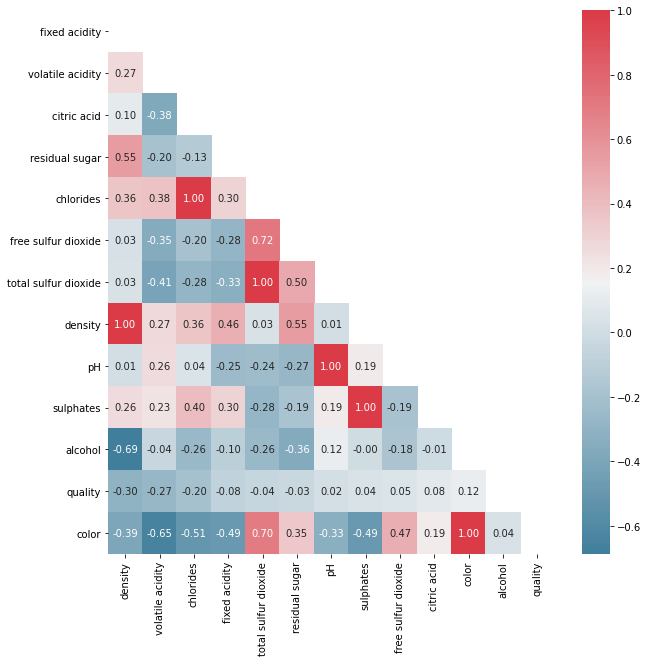

In [ ]:
import numpy as np
fig, ax = plt.subplots(1, 1, figsize = (10,10))

# create a mask to white-out the upper triangle
mask = np.triu(np.ones_like(df.corr().sort_values(by=['quality'], axis=1),
                            dtype=bool))

# we'll want a divergent colormap for this so our eye
# is not attracted to the values close to 0
cmap = sns.diverging_palette(230, 10, as_cmap=True)

sns.heatmap(df.corr().sort_values(by=['quality'], axis=1), mask=mask, cmap=cmap,
            ax=ax, annot=True, fmt=".2f")

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



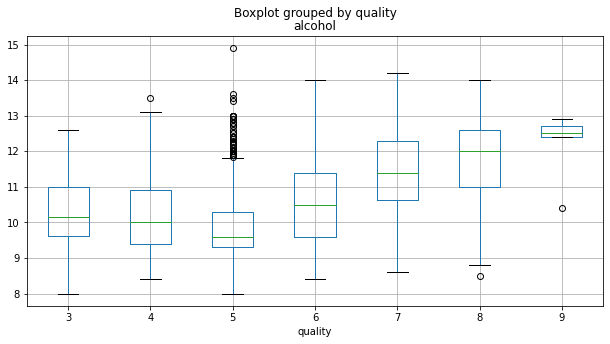

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(10,5))
df.boxplot(column='alcohol', by='quality', ax=ax)

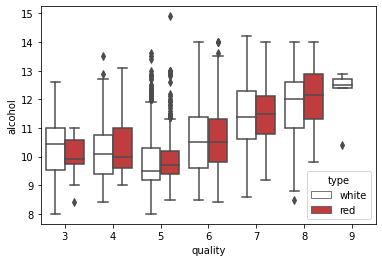

In [ ]:
sns.boxplot(x='quality', y='alcohol', hue='type', data=df, 
            palette={"red": "tab:red", "white": "white"})

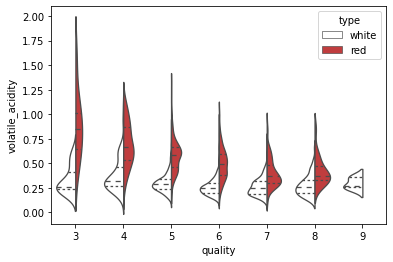

In [ ]:
sns.violinplot(x='quality', y='volatile_acidity', hue='type', data=df, 
               split=True, inner='quart', linewidth=1.3,
               palette={'red': 'tab:red', 'white': 'white'})

<a name='engineering'></a>
## 7.3 Feature Engineering
[back to top](#top)

<a name='skewness'></a>
### 7.3.1 Feature Skewness
[back to top](#top)

**Model bias and spurious interactions**: When performing a regression or any statistical modeling, asymmetrical behavior may lead to a bias in the model. In this course, we won't cover the more advanced methods of dealing with skewness (we are covering this in course 2) but we would like to make a nod to it here. 

One method to deal with skewness is to normalize using a Box-Cox transformation. methods to detect it is the skewness factor we calculated directly in pandas [above](#type) or plotting the QQ factor.

<a name='colinearity'></a>
### 7.3.3 Feature Colinearity
[back to top](#top)

We began to touch on feature colinearity when we calculated the **pearsons correlation** between variables [above](#detectcolinearity).

The **Variance Inflation Factor (VIF)** is a measure of collinearity among predictor variables within a multiple regression. It is may be calculated for each predictor by doing a linear regression of that predictor on all the other predictors, and then obtaining the R2 from that regression.

Generally, we could run the same model twice, once with severe multicollinearity and once with moderate multicollinearity. This provides a great head-to-head comparison and it reveals the classic effects of multicollinearity. However, when standardizing your predictors doesn't work, you can try other solutions such as:

* removing highly correlated predictors
* linearly combining predictors, such as adding them together
* running entirely different analyses, such as partial least squares regression or principal components analysis

Multicollinearity occurs when there are two or more independent variables in a multiple regression model, which have a high correlation among themselves. When some features are highly correlated, we might have difficulty in distinguishing between their individual effects on the dependent variable. Multicollinearity can be detected using various techniques, one such technique being the Variance Inflation Factor(VIF).

In VIF method, we pick each feature and regress it against all of the other features. For each regression, the factor is calculated as :

VIF=\frac{1}{1-R^2}

Where, R-squared is the coefficient of determination in linear regression. Its value lies between 0 and 1.

> How does a higher R2 effect colinearity?

In [ ]:
def VRF(predict, data, y):
   
    scale = StandardScaler(with_std=False)
    dff = pd.DataFrame(scale.fit_transform(data), columns= cols)
    features = "+".join(cols)
    dff[predict] = y.values

    # get y and X dataframes based on this regression:
    y, X = dmatrices(predict + ' ~' + features, data = dff, 
                     return_type='dataframe')

   # Calculate VIF Factors
    # For each X, calculate VIF and save in dataframe
    vif = pd.DataFrame()
    vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in 
                         range(X.shape[1])]
    vif["features"] = X.columns

    # Inspect VIF Factors
    vif['Recommendation'] = vif['VIF Factor'].apply(lambda x: 'Drop' 
                                                    if x > 5 else 'Keep')
    display(vif.sort_values('VIF Factor'))
    return vif

cols = df.columns.str.replace(' ', '_')
dff = df.copy()
dff.columns = cols

class_tp = {'red': 0, 'white': 1}
y_tp = df['type'].map(class_tp)

class_ql = {'low':0, 'medium': 1, 'high': 2}
y_ql = df['quality_label'].map(class_ql)

cols = list(cols.drop(['type', 'quality_label', 'quality']))

vif = VRF('quality_label', dff.loc[:, cols], y_ql)

,VIF Factor,features,Recommendation
0,1.329817,Intercept,Keep
10,1.622089,sulphates,Keep
5,1.622206,chlorides,Keep
3,1.680419,citric_acid,Keep
2,2.029538,volatile_acidity,Keep
6,2.234308,free_sulfur_dioxide,Keep
9,2.900421,pH,Keep
7,3.086628,total_sulfur_dioxide,Keep
11,4.262804,alcohol,Keep
1,5.069883,fixed_acidity,Drop


In [ ]:
vif = VRF('type', dff.loc[:, cols], y_tp)

,VIF Factor,features,Recommendation
0,1.000009,Intercept,Keep
10,1.540692,sulphates,Keep
3,1.607891,citric_acid,Keep
5,1.631957,chlorides,Keep
2,1.952668,volatile_acidity,Keep
6,2.139176,free_sulfur_dioxide,Keep
9,2.534099,pH,Keep
7,2.939275,total_sulfur_dioxide,Keep
11,4.792509,alcohol,Keep
1,4.909049,fixed_acidity,Keep


<a name='normalization'></a>
### 7.3.2 Feature Normalization
[back to top](#top)

<a name='selection'></a>
### 7.3.4 Feature Selection
[back to top](#top)

<a name='dimensionality'></a>
### 7.3.5 Dimensionality Reduction
[back to top](#top)

<a name='modeling'></a>
## 7.4 Modeling
[back to top](#top)

First we will make some support functions help us evaluate ours models through a standard. Next, we proceed with the classifications of wines types and next of wines quality labels. We will finalize our quality classification model with a staking approach.

<a name='winetype'></a>
### 7.4.1 Wine Type
[back to top](#top)

Since it is a binary classification task, we try first with a simple logistic regression.

This class implements regularized logistic regression using the 'liblinear' library, 'newton-cg', 'sag' and 'lbfgs' solvers. It can handle both dense and sparse input.

In [ ]:
cols = df.columns
cols = list(cols.drop(['type', 'type_encoding', 'quality', 'quality_encoding', 
                       'quality_label']))
X_train, X_test, y_train, y_test = train_test_split(df.loc[:, cols], y_tp,
                                      test_size=0.20, random_state=42)

In [ ]:
model = LogisticRegression(penalty='l2',
                           tol=.001,
                           C=.003,
                           class_weight='balanced',
                           solver='sag',
                           max_iter=1e6)

In [ ]:
model.fit(X_train, y_train)

LogisticRegression(C=0.003, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=1000000.0, multi_class='auto', n_jobs=None,
                   penalty='l2', random_state=None, solver='sag', tol=0.001,
                   verbose=0, warm_start=False)

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
print("Accuracy: {:.2f}".format((len(y_pred)-np.sum(np.abs(y_test-y_pred)))/len(y_pred)))

Accuracy: 0.93


In [ ]:
true_labels = y_test
predicted_labels = y_pred

print('Accuracy:  {:2.2%} '.format(metrics.accuracy_score(true_labels, predicted_labels)))
print('Precision: {:2.2%} '.format(metrics.precision_score(true_labels, predicted_labels, average='weighted')))
print('Recall:    {:2.2%} '.format(metrics.recall_score(true_labels, predicted_labels, average='weighted')))
print('F1 Score:  {:2.2%} '.format(metrics.f1_score(true_labels, predicted_labels, average='weighted')))

Accuracy:  92.73% 
Precision: 93.03% 
Recall:    92.73% 
F1 Score:  92.83% 


In [ ]:
total_classes = len(target_names)
level_labels = [total_classes*[0], list(range(total_classes))]
cm = metrics.confusion_matrix(y_true=true_labels, y_pred=predicted_labels)

NameError: ignored

In [ ]:

cm_frame = pd.DataFrame(data=cm, 
                        columns=pd.MultiIndex(levels=[['Predicted:'], target_names], labels=level_labels), 
                        index=pd.MultiIndex(levels=[['Actual:'], target_names], labels=level_labels)) 
print(cm_frame) 

<a name='winequality'></a>
### 7.4.2 Wine Quality
[back to top](#top)

In [ ]:
def get_results(model, name, data, true_labels, target_names = ['red', 'white'], results=None, reasume=False):
  
    if hasattr(model, 'layers'):
        param = wtp_dnn_model.history.params
        best = np.mean(wtp_dnn_model.history.history['val_acc'])
        predicted_labels = model.predict_classes(data) 
        im_model = InMemoryModel(model.predict, examples=data, target_names=target_names)

    else:
        param = gs.best_params_
        best = gs.best_score_
        predicted_labels = model.predict(data).ravel()
        if hasattr(model, 'predict_proba'):
            im_model = InMemoryModel(model.predict_proba, examples=data, target_names=target_names)
        elif hasattr(clf, 'decision_function'):
            im_model = InMemoryModel(model.decision_function, examples=data, target_names=target_names)
        
    print('Mean Best Accuracy: {:2.2%}'.format(best))
    print('-'*60)
    print('Best Parameters:')
    print(param)
    print('-'*60)
    
    y_pred = model.predict(data).ravel()
    
    display_model_performance_metrics(true_labels, predicted_labels = predicted_labels, target_names = target_names)
    if len(target_names)==2:
        ras = roc_auc_score(y_true=true_labels, y_score=y_pred)
    else:
        roc_auc_multiclass, ras = roc_auc_score_multiclass(y_true=true_labels, y_score=y_pred, target_names=target_names)
        print('\nROC AUC Score by Classes:\n',roc_auc_multiclass)
        print('-'*60)

    print('\n\n              ROC AUC Score: {:2.2%}'.format(ras))
    prob, score_roc, roc_auc = plot_model_roc_curve(model, data, true_labels, label_encoder=None, class_names=target_names)
    
    interpreter = Interpretation(data, feature_names=cols)
    plots = interpreter.feature_importance.plot_feature_importance(im_model, progressbar=False, n_jobs=1, ascending=True)
    
    r1 = pd.DataFrame([(prob, best, np.round(accuracy_score(true_labels, predicted_labels), 4), 
                         ras, roc_auc)], index = [name],
                         columns = ['Prob', 'CV Accuracy', 'Accuracy', 'ROC AUC Score', 'ROC Area'])
    if reasume:
        results = r1
    elif (name in results.index):        
        results.loc[[name], :] = r1
    else: 
        results = results.append(r1)
        
    return results

def roc_auc_score_multiclass(y_true, y_score, target_names, average = "macro"):

  #creating a set of all the unique classes using the actual class list
  unique_class = set(y_true)
  roc_auc_dict = {}
  mean_roc_auc = 0
  for per_class in unique_class:
    #creating a list of all the classes except the current class 
    other_class = [x for x in unique_class if x != per_class]

    #marking the current class as 1 and all other classes as 0
    new_y_true = [0 if x in other_class else 1 for x in y_true]
    new_y_score = [0 if x in other_class else 1 for x in y_score]
    num_new_y_true = sum(new_y_true)

    #using the sklearn metrics method to calculate the roc_auc_score
    roc_auc = roc_auc_score(new_y_true, new_y_score, average = average)
    roc_auc_dict[target_names[per_class]] = np.round(roc_auc, 4)
    mean_roc_auc += num_new_y_true * np.round(roc_auc, 4)
    
  mean_roc_auc = mean_roc_auc/len(y_true)  
  return roc_auc_dict, mean_roc_auc

def get_metrics(true_labels, predicted_labels):
    
    print('Accuracy:  {:2.2%} '.format(metrics.accuracy_score(true_labels, predicted_labels)))
    print('Precision: {:2.2%} '.format(metrics.precision_score(true_labels, predicted_labels, average='weighted')))
    print('Recall:    {:2.2%} '.format(metrics.recall_score(true_labels, predicted_labels, average='weighted')))
    print('F1 Score:  {:2.2%} '.format(metrics.f1_score(true_labels, predicted_labels, average='weighted')))
                        

def train_predict_model(classifier,  train_features, train_labels,  test_features, test_labels):
    # build model    
    classifier.fit(train_features, train_labels)
    # predict using model
    predictions = classifier.predict(test_features) 
    return predictions    


def display_confusion_matrix(true_labels, predicted_labels, target_names):
    
    total_classes = len(target_names)
    level_labels = [total_classes*[0], list(range(total_classes))]

    cm = metrics.confusion_matrix(y_true=true_labels, y_pred=predicted_labels)
    cm_frame = pd.DataFrame(data=cm, 
                            columns=pd.MultiIndex(levels=[['Predicted:'], target_names], labels=level_labels), 
                            index=pd.MultiIndex(levels=[['Actual:'], target_names], labels=level_labels)) 
    print(cm_frame) 
    
def display_classification_report(true_labels, predicted_labels, target_names):

    report = metrics.classification_report(y_true=true_labels, y_pred=predicted_labels, target_names=target_names) 
    print(report)
    
def display_model_performance_metrics(true_labels, predicted_labels, target_names):
    print('Model Performance metrics:')
    print('-'*30)
    get_metrics(true_labels=true_labels, predicted_labels=predicted_labels)
    print('\nModel Classification report:')
    print('-'*30)
    display_classification_report(true_labels=true_labels, predicted_labels=predicted_labels, target_names=target_names)
    print('\nPrediction Confusion Matrix:')
    print('-'*30)
    display_confusion_matrix(true_labels=true_labels, predicted_labels=predicted_labels, target_names=target_names)


def plot_model_roc_curve(clf, features, true_labels, label_encoder=None, class_names=None):
    
    ## Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    if hasattr(clf, 'classes_'):
        class_labels = clf.classes_
    elif label_encoder:
        class_labels = label_encoder.classes_
    elif class_names:
        class_labels = class_names
    else:
        raise ValueError('Unable to derive prediction classes, please specify class_names!')
    n_classes = len(class_labels)
   
    if n_classes == 2:
        if hasattr(clf, 'predict_proba'):
            prb = clf.predict_proba(features)
            if prb.shape[1] > 1:
                y_score = prb[:, prb.shape[1]-1] 
            else:
                y_score = clf.predict(features).ravel()
            prob = True
        elif hasattr(clf, 'decision_function'):
            y_score = clf.decision_function(features)
            prob = False
        else:
            raise AttributeError("Estimator doesn't have a probability or confidence scoring system!")
        
        fpr, tpr, _ = roc_curve(true_labels, y_score)      
        roc_auc = auc(fpr, tpr)

        plt.plot(fpr, tpr, label='ROC curve (area = {0:3.2%})'.format(roc_auc), linewidth=2.5)
        
    elif n_classes > 2:
        if  hasattr(clf, 'clfs_'):
            y_labels = label_binarize(true_labels, classes=list(range(len(class_labels))))
        else:
            y_labels = label_binarize(true_labels, classes=class_labels)
        if hasattr(clf, 'predict_proba'):
            y_score = clf.predict_proba(features)
            prob = True
        elif hasattr(clf, 'decision_function'):
            y_score = clf.decision_function(features)
            prob = False
        else:
            raise AttributeError("Estimator doesn't have a probability or confidence scoring system!")
            
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_labels[:, i], y_score[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        ## Compute micro-average ROC curve and ROC area
        fpr["micro"], tpr["micro"], _ = roc_curve(y_labels.ravel(), y_score.ravel())
        roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

        ## Compute macro-average ROC curve and ROC area
        # First aggregate all false positive rates
        all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
        # Then interpolate all ROC curves at this points
        mean_tpr = np.zeros_like(all_fpr)
        for i in range(n_classes):
            mean_tpr += interp(all_fpr, fpr[i], tpr[i])
        # Finally average it and compute AUC
        mean_tpr /= n_classes
        fpr["macro"] = all_fpr
        tpr["macro"] = mean_tpr
        roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

        ## Plot ROC curves
        plt.figure(figsize=(6, 4))
        plt.plot(fpr["micro"], tpr["micro"], label='micro-average ROC curve (area = {0:2.2%})'
                       ''.format(roc_auc["micro"]), linewidth=3)

        plt.plot(fpr["macro"], tpr["macro"], label='macro-average ROC curve (area = {0:2.2%})'
                       ''.format(roc_auc["macro"]), linewidth=3)

        for i, label in enumerate(class_names):
            plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:2.2%})'
                                           ''.format(label, roc_auc[i]), linewidth=2, linestyle=':')
        roc_auc = roc_auc["macro"]   
    else:
        raise ValueError('Number of classes should be atleast 2 or more')
        
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([-0.01, 1.0])
    plt.ylim([0.0, 1.01])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()
    
    return prob, y_score, roc_auc